# Entropic Regularisation to solve Discrete Optimal Transport

<div class="alert alert-block alert-success">
    
This notebook we aim at solving DOT instances using modern optimisation algorithms that outperform the simplex method. To do this we will use the Entropic Regularisation framework. 
    
The Entropic Regularisation algorithm is tested. The results are automatically stored with an unique identifier and some performance plots are presented.
</div>


* M. Cuturi. <i> Sinkhorn Distances : Lightspeed Computation of Optimal Transport </i>. Advances in Neural Information Processing Systems (NIPS) 26, 2013.

<div class="alert alert-block alert-info">
Packages
</div>

In [1]:
import numpy  as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt

# Particular functions
from numpy import zeros, zeros_like, allclose, where, ones, inf, absolute, linspace, asarray, maximum, minimum
from numpy import empty, divide, exp, isnan, isinf, einsum
from numpy.random import default_rng as rng
from numba import jit
from scipy.spatial.distance import cdist
from scipy.linalg import norm

# Algorithm

Now, we will run the Primal Dual algorithm addapted for DOT. To test it, we will run it against some of the DOTMark files. We will aim to transport from one given image to another, which are normalised and flattened in ```C```-order. The matrix of costs is based on a uniform grid within $[0,1]^2$ with $M$ points for the source and $N$ points for the target.

## Instance information

In [2]:
folder = 'Microscopy_Sized'
path = 'Exact/' + folder + '/'

In [3]:
files = [f[:-9] for f in os.listdir(path) if f.endswith('.txt')]
print('There are', len(files), 'instances in this location:')
display(files)

There are 4 instances in this location:


['data16_1002-data16_1010_p=S2',
 'data8_1002-data8_1010_p=S2',
 'data32_1002-data32_1010_p=S2',
 'data64_1002-data64_1010_p=S2']

Select one instance:

In [4]:
instance = files[2]
full_path = path + instance

Load data:

In [5]:
m = np.load(full_path + '_m.npy');    M = m.size
n = np.load(full_path + '_n.npy');    N = n.size
c = np.load(full_path + '_Cost.npy')
sol = np.load(full_path + '_Sol.npy')

In [6]:
with open(full_path + '_Time.txt', 'r') as f:
    obj_exact = eval((f.readlines())[0])['Obj']

## Run algorithm

<div class="alert alert-block alert-warning">
    
In what follows, we provide tests for the chosen instance running the Entropic Regularisation approach given by M. Cuturi in 2013.

In [7]:
### from https://github.com/rflamary/POT/blob/master/ot/bregman.py ###
def sinkhorn_knopp(M,a,b, reg, numItermax=1000,
                   stopThr=1e-9, verbose=False,collect_obj = False, 
                   true_obj = None, true_obj_tol = 1e-4,
                   true_solution = None, save_iter = False, **kwargs):
    r"""
    Solve the entropic regularization optimal transport problem and return the OT matrix
    The function solves the following optimization problem:
    .. math::
        γ = argmin_γ <γ,M>_F + reg\cdot Ω(γ)
        s.t. γ 1 = a
             γᵀ1 = b
             γ   ≥ 0
    where :
    - M is the (dim_a, dim_b) metric cost matrix
    - Ω is the entropic regularization term `Ω(γ) = Σ_{i,j} γ_{i,j} log(γ_{i,j})`
    - a and b are source and target weights (histograms, both sum to 1)
    The algorithm used for solving the problem is the Sinkhorn-Knopp matrix scaling algorithm as proposed in [2]
    Parameters
    ----------
    a : ndarray, shape (dim_a,)
        samples weights in the source domain
    b : ndarray, shape (dim_b,) or ndarray, shape (dim_b, n_hists)
        samples in the target domain, compute sinkhorn with multiple targets
        and fixed M if b is a matrix (return OT loss + dual variables in log)
    M : ndarray, shape (dim_a, dim_b)
        loss matrix
    reg : float
        Regularization term >0
    numItermax : int, optional
        Max number of iterations
    stopThr : float, optional
        Stop threshol on error (>0)
    verbose : bool, optional
        Print information along iterations
    log : bool, optional
        record log if True
    Returns
    -------
    gamma : ndarray, shape (dim_a, dim_b)
        Optimal transportation matrix for the given parameters
    log : dict
        log dictionary return only if log==True in parameters
    References
    ----------
    .. [2] M. Cuturi, Sinkhorn Distances: Lightspeed Computation of Optimal Transport, 
                                          Advances in Neural Information Processing Systems (NIPS) 26, 2013
    See Also
    --------
    ot.lp.emd : Unregularized OT
    ot.optim.cg : General regularized OT
    """
    #Initialisations
    
    '''a = asarray(a, dtype=np.float64)
    b = asarray(b, dtype=np.float64)
    M = asarray(M, dtype=np.float64)''' 
    x,xₚ = zeros((2,M.shape[0],M.shape[1]))

    if len(a) == 0:
        a = np.ones((M.shape[0],), dtype=np.float64) / M.shape[0]
    if len(b) == 0:
        b = np.ones((M.shape[1],), dtype=np.float64) / M.shape[1]

    # init data
    dim_a = len(a)
    dim_b = len(b)

    if len(b.shape) > 1:
        n_hists = b.shape[1]
    else:
        n_hists = 0
        
    if n_hists:
        u = ones((dim_a, n_hists)) / dim_a
        v = ones((dim_b, n_hists)) / dim_b
    else:
        u = ones(dim_a) / dim_a
        v = ones(dim_b) / dim_b
        
    K = empty(M.shape, dtype=M.dtype);    divide(M, -reg, out=K);    exp(K, out=K)

    # print(np.min(K))
    tmp2 = empty(b.shape, dtype=M.dtype)

    Kp = (1.0 / (a+ 1e-299)).reshape(-1, 1) * K
    cpt = 0
    err = 1
    
    '''
        Information from true solution (if available)
    '''
    # Store current objective value
    if collect_obj == True:
        x   = u.reshape((-1, 1)) * K * v.reshape((1, -1))
        obj = [(M*x).sum()]
    
    # Norm of true solution
    if true_solution is not None:
        true_obj_crit = 1.0
        if true_obj is None:
            true_obj = (M*sol).sum()
        print('Objective from ground truth:', obj_exact,'\n')
       
    
    '''
        Iterate the Entropic Regularisation scheme
    '''
    
    every_iter = {
        'it':[], 'obj':[], 'dist_obj':[], 'time':[], 'dist_x':[], 'rel_var':[], 
        'hyperₘ':{'L2': [], 'max': [], 'min':[]}, 'hyperₙ':{'L2': [], 'max': [], 'min':[]}
                 }
    every_critical = {'it':[], 'obj':[], 'tol':[], 'dist_obj':[], 'time':[], 'dist_x':[]}
    
    if true_solution is not None:
        print('     It  |  Tolerance |        Time       | Frob. dist. ')
        print( '{:-^55}'.format('') )
    
    #Initial Time
    timed = 0.0
    
    while (err > stopThr and cpt < numItermax):
        
        it_time = time.time()
        
        uprev = u
        vprev = v

        KtransposeU = np.dot(K.T, u)
        v = divide(b, (KtransposeU+ 1e-299))
        u = 1. / (np.dot(Kp, v)+ 1e-299)

        if (np.any(KtransposeU == 0)
                or np.any(isnan(u)) or np.any(isnan(v))
                or np.any(isinf(u)) or np.any(isinf(v))):
            # we have reached the machine precision
            # come back to previous solution and quit loop
            print('Warning: numerical errors at iteration', cpt)
            u = uprev
            v = vprev
            break
        if cpt % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations
            if n_hists:
                einsum('ik,ij,jk->jk', u, K, v, out=tmp2)
            else:
                # compute right marginal tmp2= (diag(u)Kdiag(v))^T1
                einsum('i,ij,j->j', u, K, v, out=tmp2)
            err = norm(tmp2 - b)  # violation of marginal
            if verbose:
                if cpt % 200 == 0:
                    print(
                        '{:5s}|{:12s}'.format('It.', 'Err') + '\n' + '-' * 19)
                print('{:5d}|{:8e}|'.format(cpt, err))
        
        # Measure time up to this point!
        end = time.time()
        timed += end - it_time
        
        # Compute current 
        x = u.reshape((-1, 1)) * K * v.reshape((1, -1))
        
        # Update objective function
        if collect_obj == True:
            obj.append( (M * x).sum() )
            # Compute relative objective distance
            if true_solution is not None:
                dist_true_sol = abs(obj[-1] - true_obj)/true_obj
        
        # If all iterations are to be stored:
        if save_iter == True:
            frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
            r, s   = x.sum(1) - a, x.sum(0) - b
            
            every_iter['it'].append(cpt)
            every_iter['obj'].append(obj[-1])
            every_iter['dist_obj'].append( dist_true_sol if true_obj is not None else np.nan )
            every_iter['time'].append( timed )
            every_iter['dist_x'].append( frob_d )
            every_iter['rel_var'].append( norm(xₚ-x, 'fro')/norm(x, 'fro') if not allclose(x,0) else np.nan )
            # Constrained satisfactibility
            every_iter['hyperₘ']['L2'].append( norm(r)/norm(a) )
            every_iter['hyperₘ']['max'].append( abs(r/maximum(a,1e-7)).max() )
            every_iter['hyperₘ']['min'].append( abs(r/maximum(a,1e-7)).min() )
            every_iter['hyperₙ']['L2'].append( norm(s)/norm(b) )
            every_iter['hyperₙ']['max'].append( abs(s/maximum(b,1e-7)).max() )
            every_iter['hyperₙ']['min'].append( abs(s/maximum(b,1e-7)).min() )
        
        # If a true solution is available, we check the tolerance:
        if true_solution is not None: 
            if dist_true_sol < true_obj_crit:
                frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
                
                every_critical['it'].append( cpt )
                every_critical['obj'].append( obj[-1] )
                every_critical['tol'].append( true_obj_crit )
                every_critical['dist_obj'].append( dist_true_sol )
                every_critical['time'].append( timed )
                every_critical['dist_x'].append( frob_d )
                
                print('* {0:6.0f} |    {1:.1e} | {2:15.2f} s |    {3:4.4f}'.format(cpt,true_obj_crit,
                                                                                   timed,frob_d))
                
                # If the prescribed tolerance is reached, we finish.
                if dist_true_sol < true_obj_tol:
                    print('Solution found with given tolerance.')
                    break
                
                # Adjust current level of inner tolerance
                true_obj_crit *= 0.1
                
                
        # Update previous step
        xₚ = x.copy()
                
        cpt = cpt + 1 #number of iterations

    if true_solution is not None:
        print( '{:-^55}'.format('') )
    
    print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(timed,cpt))
    
    if collect_obj == False and save_iter == True:
        return x, every_iter
    if collect_obj == True and save_iter == True:
        return x, obj, every_critical, every_iter
    else:
        return x

In [8]:
x, obj, every_critical, every_iter = sinkhorn_knopp(c,m,n,0.0002, numItermax= 10000, collect_obj = True, true_obj = obj_exact,true_obj_tol = 1e-7,true_solution = sol, save_iter = True)

Objective from ground truth: 0.010675024052995653 

     It  |  Tolerance |        Time       | Frob. dist. 
-------------------------------------------------------
*      0 |    1.0e+00 |            0.01 s |    1.6422
*   1551 |    1.0e-01 |            1.25 s |    0.6304
*   3933 |    1.0e-02 |            3.21 s |    0.3706
*   5747 |    1.0e-03 |            4.71 s |    0.3649
*   6477 |    1.0e-04 |            5.31 s |    0.3648
*   6591 |    1.0e-05 |            5.41 s |    0.3648
*   6603 |    1.0e-06 |            5.42 s |    0.3648
*   6604 |    1.0e-07 |            5.42 s |    0.3648
Solution found with given tolerance.
-------------------------------------------------------

Algorithm stopped after 5.4222 seconds and 6604 iterations


## Visualise and store results

In [9]:
main_folder = folder + '_Results'
out_folder  = main_folder + '/' + instance
algorithm   = 'ER-'

In [10]:
# Check if main folder for results exists, else create it
if not os.path.exists(main_folder):    os.makedirs(main_folder)
# Now create a folder for the results of the instance
if not os.path.exists(out_folder):    os.makedirs(out_folder)
out_folder += '/' + algorithm

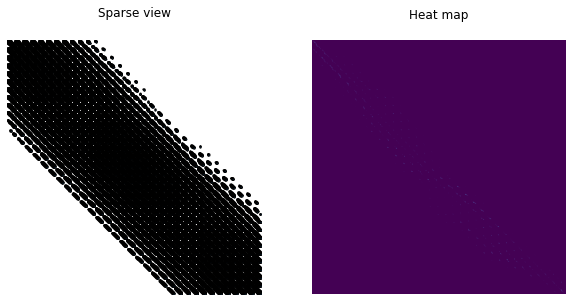

In [11]:
# Visualise solution
plt.figure(figsize = (10,5))

plt.subplot(1, 2, 1)
plt.spy(x, markersize=1, aspect = 1, markeredgecolor = 'black', alpha=0.75);    plt.axis('off')
plt.title('Sparse view')
plt.subplot(1, 2, 2)
plt.imshow(x);    plt.axis('off');    plt.title('Heat map\n')

plt.savefig(out_folder+'Sparse-Heat.pdf', bbox_inches='tight',transparent=True)
plt.show()

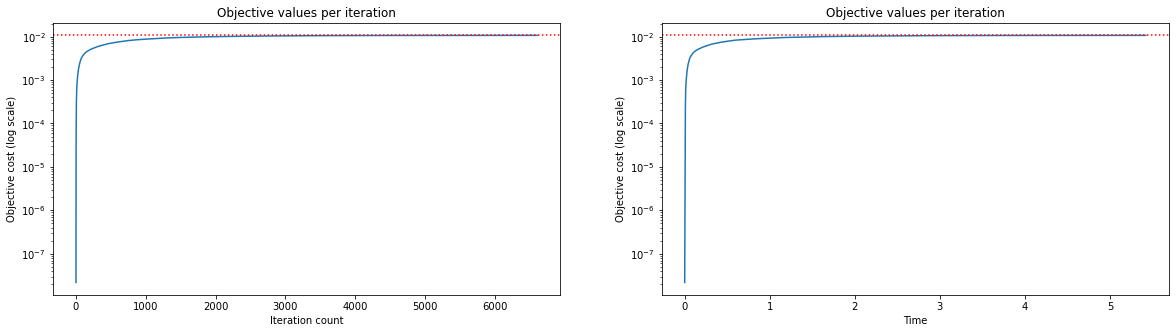

In [12]:
# Visualise evolution of objective values
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(obj)
plt.axhline(y=obj_exact, color='r', linestyle=':')
plt.yscale('log');    plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')
plt.subplot(1, 2, 2)
plt.plot(np.append([0], every_iter['time']),obj)
plt.axhline(y=obj_exact, color='r', linestyle=':')
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Time');    plt.ylabel('Objective cost (log scale)')

plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

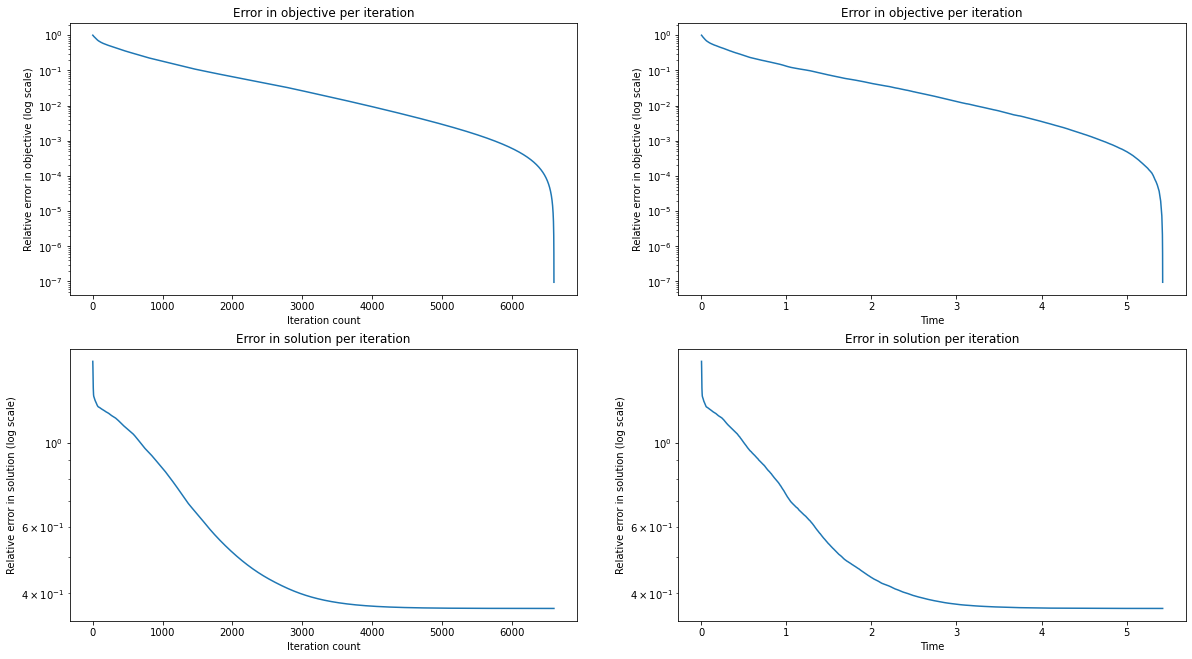

In [13]:
# Visualise evolution of relative errors
plt.figure(figsize = (20,11))

plt.subplot(2, 2, 1)
plt.plot(every_iter['dist_obj'])
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in objective (log scale)')
plt.subplot(2, 2, 2)
plt.plot(every_iter['time'],every_iter['dist_obj'])
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Time');    plt.ylabel('Relative error in objective (log scale)')
plt.subplot(2, 2, 3)
plt.plot(every_iter['dist_x'])
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in solution (log scale)')
plt.subplot(2, 2, 4)
plt.plot(every_iter['time'],every_iter['dist_x'])
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Time');    plt.ylabel('Relative error in solution (log scale)')

plt.savefig(out_folder+'Rel_Error.pdf', bbox_inches='tight',transparent=True)
plt.show()

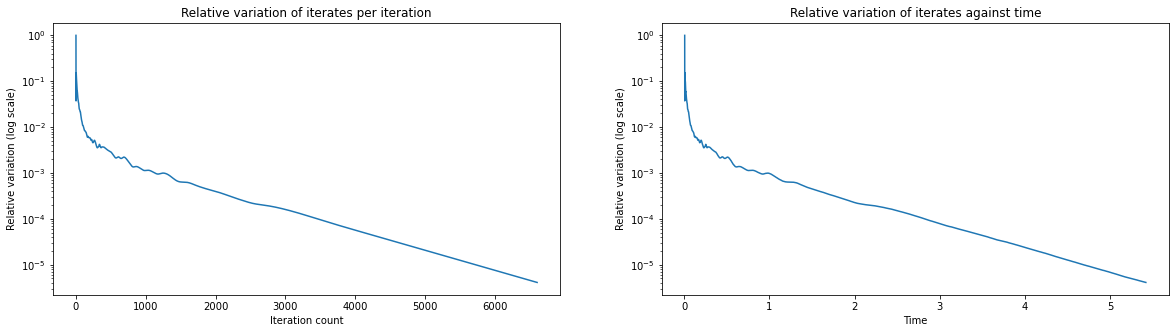

In [14]:
# Relative variation
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['rel_var'])
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative variation (log scale)');
plt.title('Relative variation of iterates per iteration')

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['rel_var'])
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative variation (log scale)');
plt.title('Relative variation of iterates against time')

plt.savefig(out_folder+'Relative_Var.pdf', bbox_inches='tight',transparent=True)
plt.show()

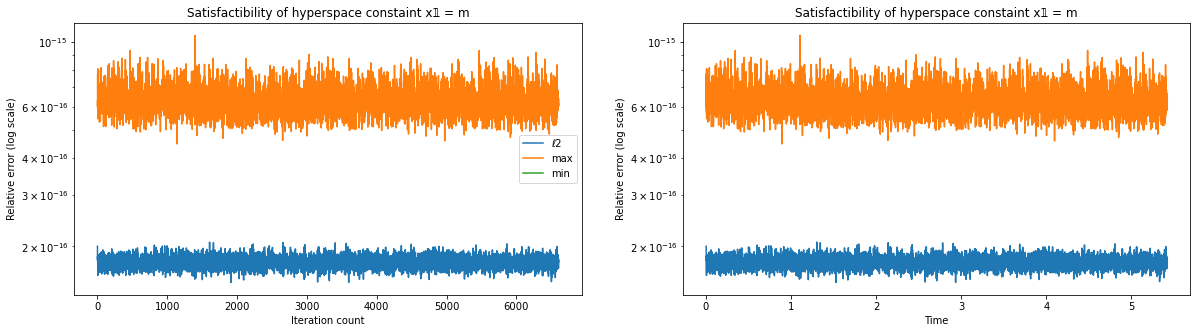

In [15]:
# Relative variation for x𝟙 = m
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter['it'], every_iter['hyperₘ']['max'], label='max')
plt.plot(every_iter['it'], every_iter['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint x𝟙 = m')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['hyperₘ']['L2'], label='ℓ2')
plt.plot(every_iter['time'], every_iter['hyperₘ']['max'], label='max')
plt.plot(every_iter['time'], every_iter['hyperₘ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint x𝟙 = m')

plt.savefig(out_folder+'RelE_m.pdf', bbox_inches='tight',transparent=True)
plt.show()

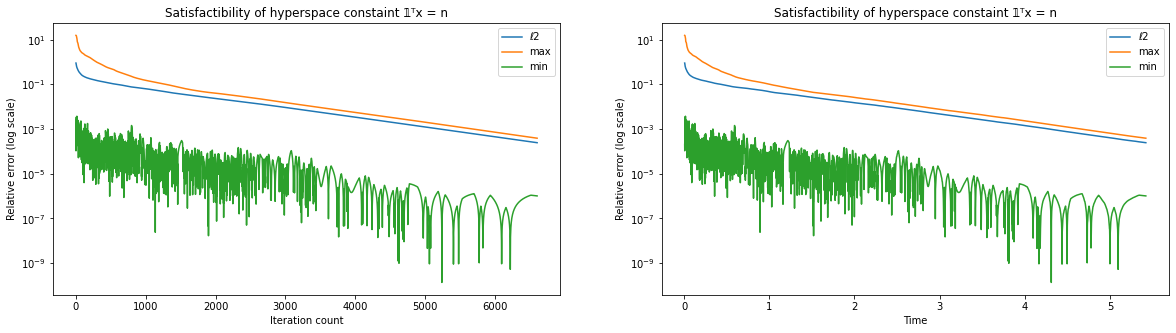

In [16]:
# Relative variation for 𝟙ᵀx = n
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['it'], every_iter['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter['it'], every_iter['hyperₙ']['max'], label='max')
plt.plot(every_iter['it'], every_iter['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Iteration count');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint 𝟙ᵀx = n');    plt.legend()

plt.subplot(1, 2, 2)
plt.plot(every_iter['time'], every_iter['hyperₙ']['L2'], label='ℓ2')
plt.plot(every_iter['time'], every_iter['hyperₙ']['max'], label='max')
plt.plot(every_iter['time'], every_iter['hyperₙ']['min'], label='min')
plt.yscale('log')
plt.xlabel('Time');    plt.ylabel('Relative error (log scale)');
plt.title('Satisfactibility of hyperspace constaint 𝟙ᵀx = n');    plt.legend()

plt.savefig(out_folder+'RelE_n.pdf', bbox_inches='tight',transparent=True)
plt.show()

All the data from the above two plots is also available as dataframes:

In [17]:
df_critical = pd.DataFrame.from_dict(every_critical)
df_critical.to_pickle(out_folder+'Critical.pkl') # To read back use pd.read_pickle(file_name)
df_critical.to_excel(out_folder+'Critical.xlsx')
display(df_critical)

# If we want this table in LaTeX format run:
print(df_critical.to_latex(index=False))

,it,obj,tol,dist_obj,time,dist_x
0,0,0.000025,1.000000e+00,9.977020e-01,0.005286,1.642232
1,1551,0.009608,1.000000e-01,9.995811e-02,1.253955,0.630426
2,3933,0.010568,1.000000e-02,9.991512e-03,3.214623,0.370588
3,5747,0.010664,1.000000e-03,9.986423e-04,4.710758,0.364920
4,6477,0.010674,1.000000e-04,9.938335e-05,5.313334,0.364789
5,6591,0.010675,1.000000e-05,9.513218e-06,5.409985,0.364781
6,6603,0.010675,1.000000e-06,6.397013e-07,5.421123,0.364780
7,6604,0.010675,1.000000e-07,9.492754e-08,5.422174,0.364780


\begin{tabular}{rrrrrr}
\toprule
  it &      obj &          tol &     dist\_obj &     time &   dist\_x \\
\midrule
   0 & 0.000025 & 1.000000e+00 & 9.977020e-01 & 0.005286 & 1.642232 \\
1551 & 0.009608 & 1.000000e-01 & 9.995811e-02 & 1.253955 & 0.630426 \\
3933 & 0.010568 & 1.000000e-02 & 9.991512e-03 & 3.214623 & 0.370588 \\
5747 & 0.010664 & 1.000000e-03 & 9.986423e-04 & 4.710758 & 0.364920 \\
6477 & 0.010674 & 1.000000e-04 & 9.938335e-05 & 5.313334 & 0.364789 \\
6591 & 0.010675 & 1.000000e-05 & 9.513218e-06 & 5.409985 & 0.364781 \\
6603 & 0.010675 & 1.000000e-06 & 6.397013e-07 & 5.421123 & 0.364780 \\
6604 & 0.010675 & 1.000000e-07 & 9.492754e-08 & 5.422174 & 0.364780 \\
\bottomrule
\end{tabular}



In [18]:
#df_every = pd.DataFrame.from_dict(every_iter)
df_every = pd.concat([
                pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['hyperₘ', 'hyperₙ'] } ),
                pd.DataFrame.from_dict( {'hyperₘ-'+a:b for a,b in every_iter['hyperₘ'].items()} ), 
                pd.DataFrame.from_dict( {'hyperₙ-'+a:b for a,b in every_iter['hyperₙ'].items()} )], axis = 1)
df_every.to_pickle(out_folder+'Every.pkl') # To read back use pd.read_pickle(file_name)
df_every.to_excel(out_folder+'Every.xlsx')
display(df_every.head())

,it,obj,dist_obj,time,dist_x,rel_var,hyperₘ-L2,hyperₘ-max,hyperₘ-min,hyperₙ-L2,hyperₙ-max,hyperₙ-min
0,0,0.000025,0.997702,0.005286,1.642232,1.000000,2.003184e-16,6.268648e-16,0.0,0.897292,15.583169,0.000205
1,1,0.000041,0.996163,0.005975,1.623654,0.037212,1.793931e-16,5.974114e-16,0.0,0.881416,15.529707,0.000106
2,2,0.000085,0.992046,0.006690,1.582423,0.105908,1.855580e-16,6.216777e-16,0.0,0.846274,15.469974,0.000159
3,3,0.000155,0.985506,0.007299,1.531638,0.152777,1.842526e-16,7.758831e-16,0.0,0.804009,15.395614,0.001247
4,4,0.000231,0.978363,0.008159,1.487097,0.147863,1.742776e-16,6.078721e-16,0.0,0.767053,15.288047,0.000662


In [19]:
df_every.describe()

,it,obj,dist_obj,time,dist_x,rel_var,hyperₘ-L2,hyperₘ-max,hyperₘ-min,hyperₙ-L2,hyperₙ-max,hyperₙ-min
count,6605.000000,6605.000000,6.605000e+03,6605.000000,6605.000000,6605.000000,6.605000e+03,6.605000e+03,6605.0,6605.000000,6605.000000,6.605000e+03
mean,3302.000000,0.009757,8.603281e-02,2.693052,0.532659,0.001308,1.767845e-16,6.253087e-16,0.0,0.031358,0.194856,5.969776e-05
std,1906.843596,0.001624,1.521344e-01,1.580313,0.260917,0.013713,7.915010e-18,6.217871e-17,0.0,0.064279,0.888501,1.802051e-04
min,0.000000,0.000025,9.492754e-08,0.005286,0.364780,0.000004,1.507375e-16,4.474113e-16,0.0,0.000245,0.000390,1.368741e-10
25%,1651.000000,0.009708,3.109469e-03,1.338662,0.365544,0.000022,1.713265e-16,5.867818e-16,0.0,0.001297,0.002123,9.729994e-07
50%,3302.000000,0.010469,1.931269e-02,2.699349,0.384015,0.000118,1.765267e-16,6.169278e-16,0.0,0.006849,0.011184,6.393824e-06
75%,4953.000000,0.010642,9.062521e-02,4.081354,0.598376,0.000589,1.821316e-16,6.559610e-16,0.0,0.032065,0.057048,4.584373e-05
max,6604.000000,0.010675,9.977020e-01,5.422174,1.642232,1.000000,2.069347e-16,1.049670e-15,0.0,0.897292,15.583169,3.748737e-03


In [20]:
# Finally, store the latest solution:
np.save(out_folder + '_Sol.npy' , x)            # To read back just run:   np.load(outfile)

---
Code used to do performance tests in each piece of code:
```Python
start = time.time()
# ...
end = time.time()
print(end-start)

%timeit -r 10 -n 200 `function(x)`
```

---